In [26]:
import torch
from torch import nn
from d2l import torch as d2l

In [27]:
n_train=50
x_train,_=torch.sort(torch.rand(n_train)*5)
def f(x):
    return 2*torch.sin(x)+x**0.8
y_train=f(x_train)+torch.normal(0.0,0.5,(n_train,))
x_test=torch.arange(0,5,0.1)
y_truth=f(x_test)
n_test=len(x_test)

In [28]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5)

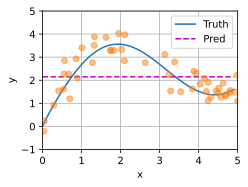

In [29]:
y_hat=torch.repeat_interleave(y_train.mean(),n_test)
plot_kernel_reg(y_hat)

tensor([[7.8612e-02, 7.8574e-02, 7.5461e-02,  ..., 3.9020e-07, 3.1461e-07,
         2.9386e-07],
        [7.3144e-02, 7.3194e-02, 7.2010e-02,  ..., 5.9305e-07, 4.8024e-07,
         4.4917e-07],
        [6.7839e-02, 6.7965e-02, 6.8498e-02,  ..., 8.9848e-07, 7.3074e-07,
         6.8440e-07],
        ...,
        [8.7784e-07, 9.2688e-07, 2.7647e-06,  ..., 4.5232e-02, 4.4717e-02,
         4.4538e-02],
        [5.6961e-07, 6.0213e-07, 1.8399e-06,  ..., 4.7942e-02, 4.7602e-02,
         4.7477e-02],
        [3.6864e-07, 3.9014e-07, 1.2212e-06,  ..., 5.0682e-02, 5.0542e-02,
         5.0478e-02]])

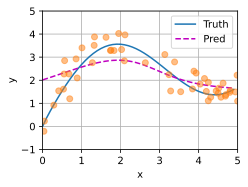

In [30]:
X_repeat=x_test.repeat_interleave(n_train).reshape((-1,n_train))
attention_weights=nn.functional.softmax(-(X_repeat-x_train)**2/2,dim=1)
y_hat=torch.matmul(attention_weights,y_train)
plot_kernel_reg(y_hat)
attention_weights


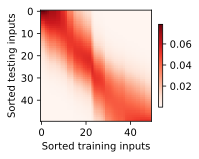

In [31]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

In [32]:
X=torch.ones((2,1,4))
Y=torch.ones((2,4,6))
torch.bmm(X,Y).shape

torch.Size([2, 1, 6])

In [33]:
weights=torch.ones((2,10))*0.1
values=torch.arange(20.0).reshape((2,10))
torch.bmm(weights.unsqueeze(1),values.unsqueeze(-1))
weights.unsqueeze(1)

tensor([[[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
          0.1000, 0.1000]],

        [[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
          0.1000, 0.1000]]])

In [40]:
class NWKernelRegression(nn.Module):
    def __init__(self,**kargs):
        super().__init__(**kargs)
        self.w=nn.Parameter(torch.rand((1,),requires_grad=True))
    def forward(self,queries,keys,values):
        queries=queries.repeat_interleave(keys.shape[1]).reshape((-1,keys.shape[1]))
        self.attention_weights=nn.functional.softmax(-((queries-keys)*self.w)**2/2,dim=1)
        return torch.bmm(self.attention_weights.unsqueeze(1),values.unsqueeze(-1)).reshape(-1)

In [41]:
X_tile=x_train.repeat((n_train,1))
Y_tile=y_train.repeat((n_train,1))
keys=X_tile[(1-torch.eye(n_train)).type(torch.bool)].reshape((n_train,-1))
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

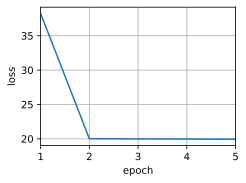

In [42]:
net=NWKernelRegression()
loss=nn.MSELoss(reduction='none')
trainer=torch.optim.SGD(net.parameters(),lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])
for epoch in range(5):
    trainer.zero_grad()
    l=loss(net(x_train,keys,values),y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch+1}, loss {float(l.sum()):.6f}')
    animator.add(epoch+1,float(l.sum()))

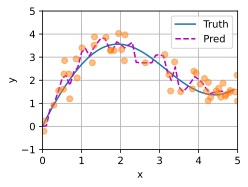

In [43]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

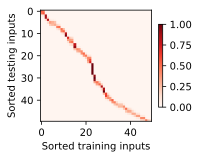

In [44]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')